# In-depth Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, auc, precision_recall_fscore_support, f1_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel 
from sklearn.metrics import adjusted_mutual_info_score, SCORERS
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split


import datetime as dt
import seaborn as sns
# df = pd.read_csv('./data/final_NYC_crimes.csv', parse_dates=[['DATE', 'TIME']])
df = pd.read_csv('./data/final_NYC_crimes.csv')

### Classification Analysis



When the true goal of data analysis is to be able to predict which of several non-overlapping groups an observation belongs to, the techniques we use are known as classification techniques.It is a Data analysis task, i.e. the process of finding a model that describes and distinguishes data classes and concepts. Classification is the problem of identifying to which of a set of categories (subpopulations), a new observation belongs to, on the basis of a training set of data containing observations and whose categories membership is known.



## Utility Functions

#### cv_score : This  will be used for scoring our model

In [2]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

#### hypertuning_fxn : This  will be used for hyperparameter tuning

In [3]:
def hypertuning_fxn(X, y, nfolds, model , param_grid, scoring = None, verbose=True, cv = True, 
                    return_train_score = True): 
    
    """function that uses GridSearchCV to test a specified param_grid of hyperparameters and choose the optimal one based on nfolds cross-validation results. 

    Keyword arguments:
    model -- a 'fitted' sklearn model object 
    X -- predictor matrix (dtype='numpy array', required)
    y -- outcome vector (dtype='numpy array', required)
    cv -- if True, prints a the roc_auc score from 10-fold crossvalidation (dtype='boolean', default='True')
    """
    
    np.random.seed(12345)
    
    # The scorers can be either be one of the predefined metric strings or a scorer
    # callable, like the one returned by make_scorer
#     scoring = {'AUC': 'roc_auc_ovr', 'Accuracy': make_scorer(accuracy_score)}

    grid_search = GridSearchCV(      estimator= model,
                                     param_grid=param_grid,
                                     cv=KFold(nfolds), # stratified k-folds will preserve class balances - this function is what got the rest of the code to work with roc validation
                                     scoring=scoring,
                                     return_train_score=True,
                                     n_jobs = -1,
                                     verbose = verbose)
    
#     scoring = {'accuracy': 'accuracy', 'auc': 'roc_auc_ovr'}
#     scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

    grid_search.fit(X, y)
    print(" scorer function: {}".format(scoring))
    print(" ##### CV performance: mean & sd scores #####")

    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    
    print('best cv score: {:0.3f}'.format(grid_search.best_score_))
    print('best cv params: ', grid_search.best_params_)

    worst_index=np.argmin(grid_search.cv_results_['mean_test_score'])
    print('worst cv score: {:0.3f}'.format(grid_search.cv_results_['mean_test_score'][worst_index]))
    print('worst cv params: ', grid_search.cv_results_['params'][worst_index])
    ##
    if verbose==True:
        for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
    
    return(grid_search)
#     print(grid_search.cv_results_)

#### evaluate_model : This  will be used for evaulating our model

In [4]:

def evaluate_model(model, x, y, cv = True):
    """prints common binary classification evaluation metrics and an ROC curve. 

    Keyword arguments:
    model -- a 'fitted' sklearn model object 
    x -- predictor matrix (dtype='numpy array', required)
    y -- outcome vector (dtype='numpy array', required)
    cv -- if True, prints  score from 5-fold crossvalidation (dtype='boolean', default='True')
    """
    import sklearn.metrics
    from sklearn.metrics import log_loss, average_precision_score, precision_recall_curve
    from sklearn.model_selection import cross_val_score


    if cv==True:
        cv_results= cross_val_score(model, x, y, scoring='roc_auc_ovo_weighted', cv=Kfold(5))
        print("across 5 fold cv on trainingset, the model had \n", 
             "mean auroc: {:0.3f}".format(np.mean(cv_results)), "\n",
             "std auroc: {:0.3f}".format(np.std(cv_results))
             )

        base_cv_score=np.mean(cross_val_score(model, x, y, scoring='roc_auc_ovo_weighted', cv=Kfold(5)))

    print("###metrics on provided dataset:###")
    
    ##basic model performance
    y_hat = model.predict(x) # predicted classes using default 0.5 threshold
    y_proba = model.predict_proba(x)[:,] #predicted probabilities
    auc=roc_auc_score(y, y_proba, multi_class = 'ovr', average = 'weighted')

    print ('the AUC is: {:0.3f}'.format(auc))
    
    # Modify labels for the classification reports
    crime_labels = list(range(0,11))
    crime_labels = np.asarray(crime_labels)
    
#     crime_names = df.CRIME_TYPE.tolist().drop_duplicates()
    
    print("classification report:\n ", classification_report(y, y_hat, labels = crime_labels, target_names = df['CRIME_TYPE'], digits=3))

    #ez_roc(model, x, y, pos_label = 1) #plotting roc curve
    #plt.show()

## Inspecting the Data

Here we can see there is a massive skew in the CRIME_TYPE we are trying to predict. We will have to resample our data so that we can hopefully get a more balanced prediction. However, this means we have to give up a large portion of the data, and can only predict from 4 CRIME_TYPEs.

In [5]:
df.head()

,CMPLNT_NUM,DISTRICT,BOROUGH,DATE,TIME,CRM_ATPT_CPTD_CD,OFFENSE LEVEL,PREM_TYP_DESC,OFFENSE_NAME,SUSP_AGE_GROUP,...,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,YEAR,MONTH,DAY,CRIME_TYPE
0,314773184,48,BRONX,2019-12-31,18:00:00,COMPLETED,FELONY,STREET,ROBBERY,UNKNOWN,...,F,1016990,244612,40.838026,-73.881681,"(40.838026269000075, -73.88168118799997)",2019,12,31,ROBBERY
1,289837961,25,MANHATTAN,2019-12-30,20:30:00,COMPLETED,MISDEMEANOR,RESIDENCE - APT. HOUSE,PETIT LARCENY,UNKNOWN,...,F,999296,230862,40.800334,-73.945657,"(40.800334261000046, -73.94565697199994)",2019,12,30,LARCENY
2,535744284,77,BROOKLYN,2019-12-24,16:55:00,COMPLETED,FELONY,STREET,FELONY ASSAULT,UNKNOWN,...,M,1001068,183317,40.669832,-73.939376,"(40.66983179600004, -73.93937555099996)",2019,12,24,ASSAULT
3,895678119,52,BRONX,2019-12-30,19:32:00,COMPLETED,MISDEMEANOR,CHAIN STORE,PETIT LARCENY,25-44,...,D,1009690,257590,40.873671,-73.908014,"(40.87367103500002, -73.90801364899994)",2019,12,30,LARCENY
4,299841674,18,MANHATTAN,2019-12-30,15:30:00,COMPLETED,MISDEMEANOR,STREET,PETIT LARCENY,UNKNOWN,...,M,985766,216503,40.760935,-73.994529,"(40.76093528000007, -73.99452906599998)",2019,12,30,LARCENY


In [6]:
df['CRIME_TYPE'].value_counts()

LARCENY                             134122
OFFENSES_AGAINST_PUBLIC_ORDER        74031
ASSAULT                              73102
HARRASSMENT                          71000
MISC_PENAL_LAW                       14048
BURGLARY                             13973
POSSESSION_CONTROLLED_SUBSSTANCE     13367
ROBBERY                              13325
FRAUD                                10876
POSSESSION_WEAPON                     7791
SEX_CRIMES                            7535
TRAFFIC_LAWS_VIOLATION                6740
DRIVING_UNDER_INFLUENCE               4366
THEFT                                 3053
UNCLASSIFIED                          1969
ARSON                                  675
MURDER                                 303
GAMBLING                               289
SOCIAL_RELATED_CRIMES                  287
KIDNAPPING                             126
Name: CRIME_TYPE, dtype: int64

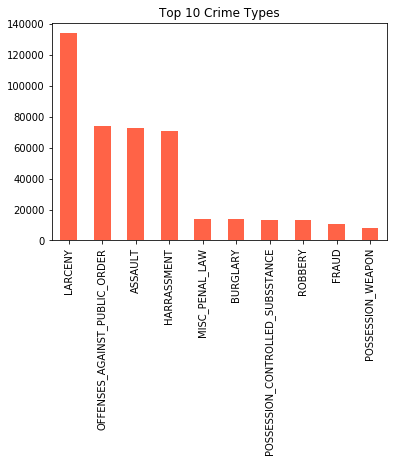

In [7]:
# Plot The top 10 crimes

crime_df10 = df.CRIME_TYPE.value_counts().head(10)

crime_df10 = pd.DataFrame(crime_df10)

plt1 = crime_df10.plot(kind="bar", color = "tomato")
plt1.tick_params(axis="x", labelsize = 10, labelrotation = 90)
plt1.set_title("Top 10 Crime Types")
plt1.get_legend().remove()

## Feature Engineering

In this step, we are resampling the data by Crime Type. We are taking the top 4 crimes, and constructing our dataset using 70,000 rows of each crime.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450978 entries, 0 to 450977
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   CMPLNT_NUM        450978 non-null  int64  
 1   DISTRICT          450978 non-null  int64  
 2   BOROUGH           450978 non-null  object 
 3   DATE              450978 non-null  object 
 4   TIME              450978 non-null  object 
 5   CRM_ATPT_CPTD_CD  450978 non-null  object 
 6   OFFENSE LEVEL     450978 non-null  object 
 7   PREM_TYP_DESC     450978 non-null  object 
 8   OFFENSE_NAME      450978 non-null  object 
 9   SUSP_AGE_GROUP    450978 non-null  object 
 10  SUSP_RACE         450978 non-null  object 
 11  SUSP_SEX          450978 non-null  object 
 12  VIC_AGE_GROUP     450978 non-null  object 
 13  VIC_RACE          450978 non-null  object 
 14  VIC_SEX           450975 non-null  object 
 15  X_COORD_CD        450978 non-null  int64  
 16  Y_COORD_CD        45

In [9]:
# Select features. Features are columns from the dataframe, except CRIME_TYPE
features = ['BOROUGH', 'DISTRICT', 'MONTH', 'VIC_AGE_GROUP', 'VIC_RACE','VIC_SEX', 'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX']

## Prepare Data 
In this step, we are resampling the data by Crime Type. We are taking the top 4 crimes, and constructing our dataset using 70,000 rows of each crime.

Then we are splitting the dataframe into X (features) and Y (results), One-Hot Encoding the categorical variables, then finally converting the dataframes into NumPy arrays and using train_test_split to get our training and testing data.

In [10]:
### Resample Data

# Step 1 : Resample Data to contain 70,000 rows each of the top 4 crimes
top_4_crimes = df['CRIME_TYPE'].value_counts().head(4).index.tolist()

# do the for loop where you filter by each crime
df_resampled = []

for crime in top_4_crimes:
    # filter df to only include this crime
    # use .head()
    new_df = df.loc[df['CRIME_TYPE'] == crime].head(70000)
    
    # append the new df to df_resampled
    df_resampled.append(new_df)
    
crime_model = pd.concat(df_resampled)

# Step 2: Divide dataset into inputs (crime_x) and output variable (crime_y)
crime_x = crime_model[features]
crime_y = crime_model[['CRIME_TYPE']]

In [11]:
# We can see here that there are multiple values that occur only once. 
# This will impair our one-hot encoding. 
# We can use thresholding to rename these values to one value


In [12]:
### One Hot Encoding Categorical variables
# Using this tutorial: https://youtu.be/YOR6rQTTEAQ

# Thresholding: (Not needed but useful information)
# This removes items that occur tiny amounts in a column. 
# By renaming these items that are under the threshold, 
# We can minimize the columns that are created through one-hot encoding

# Apply the count threshold to all the categorical values
# rows = df.shape[0]
# threshold = rows * 0.005
# print('The minimum count threshold is: '+ str(threshold))
# obj_columns = list(df.select_dtypes(include=['object']).columns) # Get a list of all the columns' names with object dtype
# obj_columns.remove('CRIME_TYPE') # remove target column
# crime_x = crime_x.apply(lambda x: x.mask(x.map(x.value_counts()) < threshold, 'RARE') if x.name in obj_columns else x)

# One-hot Encode Categorical values in crime_x
crime_x_ohe = pd.get_dummies(crime_x)

# One-hot Encode Categorical values in crime_y
crime_y.loc[:, 'CRIME_TYPE_CODE'] = pd.factorize(crime_y['CRIME_TYPE'])[0].reshape(-1,1)
crime_y_ohe = crime_y[['CRIME_TYPE_CODE']]

# Make sure crime_x and crime_y have the same rows
print(crime_x.shape[0] == crime_y.shape[0])

True


/Users/bea/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/bea/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [13]:
### Split data into train/test

# Step 5: Convert Dataframes to NumPy arrays
crime_x = np.array(crime_x_ohe)
crime_y = np.array(crime_y_ohe)

crime_y = crime_y.reshape(-1)

# Step 6 using train_test_split
x_train, x_test, y_train, y_test = train_test_split(crime_x, crime_y, test_size=0.25)

#### Resampling method for multiclass data
(Unused, but might be useful info later) Since we have skewed data, we want to resample data to make it balanced. 
The data is skewed somehow

In [14]:
# # Authors: Guillaume Lemaitre <g.lemaitre58@gmail.com>
# # License: MIT

# # Using imblearn resampling methods from:
# # https://heartbeat.fritz.ai/resampling-to-properly-handle-imbalanced-datasets-in-machine-learning-64d82c16ceaa

# from imblearn.under_sampling import RandomUnderSampler

# # create the object.
# under_sampler = RandomUnderSampler()

# # Undersampling: fit the object to the training data.
# x_train_under, y_train_under = under_sampler.fit_sample(x_train, y_train)

##  Logistic regression
Basic, no-frills Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logModel = LogisticRegression()

# Fit the model on the training data.
logModel.fit(x_train, y_train)

# Print the accuracy from the testing data.
train_score = (accuracy_score(logModel.predict(x_train), y_train))
test_score = (accuracy_score(logModel.predict(x_test), y_test))

print("Training Accuracy:",  train_score)
print("Testing Accuracy:",  test_score)

Training Accuracy: 0.5346619047619048
Testing Accuracy: 0.5343857142857142


/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Logistic Regression Confusion Matrix

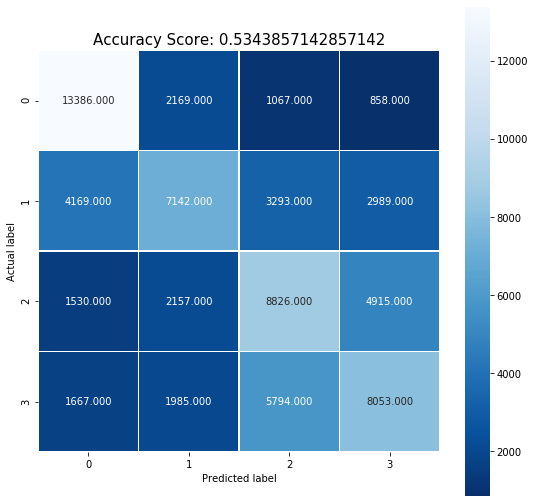

In [16]:
from sklearn import metrics

predictions = logModel.predict(x_test)

cm = metrics.confusion_matrix(y_test, predictions)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(test_score)
plt.title(all_sample_title, size = 15);

### Hyperparameter tuning

In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {
  'penalty': ['l1', 'l2', 'elasticnet'],
  'solver': ['lbgfs', 'liblinear', 'saga']
}

clf = GridSearchCV(logModel, param_grid, cv=3, verbose=True, n_jobs=-1)

In [18]:
# (Commented out) This hypertuning takes about 1 minute
# LogisticRegression(penalty='l1', solver='liblinear')

# logModel_best = clf.fit(x_train,y_train)
# logModel_best = logModel_best.best_estimator_

### Evaluate Logistic Regression using new hyperparameters

In [19]:
# Last best estimator: 
logModel_best = LogisticRegression(penalty='l1', solver='liblinear')

# Fit the model on the training data.
logModel_best.fit(x_train, y_train)

# Print the accuracy from the testing data.
train_score = logModel_best.score(x_train, y_train)
test_score = logModel_best.score(x_test, y_test)

print("Training Accuracy:",  train_score)
print("Testing Accuracy:",  test_score)

Training Accuracy: 0.5472476190476191
Testing Accuracy: 0.5458571428571428


We can see that after hyperparameter tuning, we were able to increase the testing accuracy from 0.537 to 0.548

## Random Forest
This function includes parameters for stratified cross-fold validation and supports code for hyperparameter tuning for a random forest model. Because we are working with a multi-classification problem, we evaluate our logistic regression models with one-vs-one classification.

### Basic Random Forest Classifer

In [20]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(x_train, y_train)

RandomForestClassifier()

In [21]:
train_score = (accuracy_score(rf_model.predict(x_train), y_train))
test_score = (accuracy_score(rf_model.predict(x_test), y_test))
print("Training Accuracy:",  train_score)
print("Testing Accuracy:",  test_score)

Training Accuracy: 0.8526476190476191
Testing Accuracy: 0.5092571428571429


Looks like the model is overfit to the training data. We can fix this using hyperparameter tuning.

### Random Forest Confusion Matrix


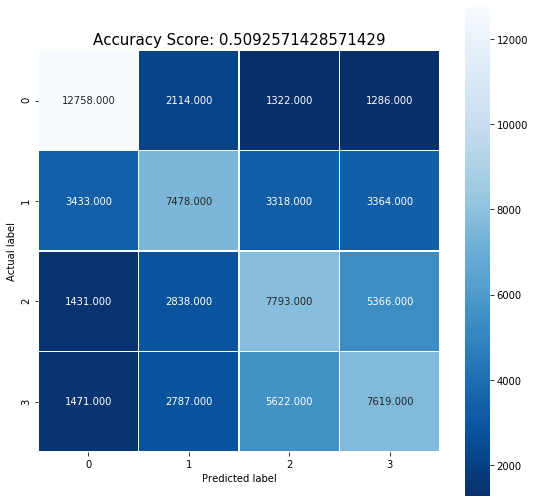

In [22]:
y_predict = rf_model.predict(x_test)

cm = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(test_score)
plt.title(all_sample_title, size = 15);


### Random Forest Hyperparameter Tuning

In [23]:
# Random Forest HyperParameters

# Number of trees in random forest
n_estimators = [ 20, 30, 50, 70]
# Number of features to consider at every split
max_features = ['auto'] # 'auto' which is equivalent to sqrt(n_features)
# Maximum number of levels in tree
max_depth = [5, 10, 15]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 5, 10]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [24]:
# Do not have to run this every time
# Tune hyperparams - This takes about 11-12 minutes. 
# best cv score: 0.564
# best cv params:  {'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 70}

t1 = time.time()

# Uncomment to run hypertuning
# rf_hyper = hypertuning_fxn(x_train, y_train, nfolds = 3, model = rf_model , param_grid = param_grid, cv = True, return_train_score = True, verbose= True)

t2 = time.time()  

run_time = t2 - t1
print('Training Time in Minutes:', run_time/60)

Training Time in Minutes: 4.80810801188151e-07


In [25]:
# Best estimator: 
# print(rf_hyper.best_estimator_)
# rf_best = rf_hyper.best_estimator_
# rf_best = RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_leaf=10, n_estimators=70, random_state=12345)

### Evaluate data using hypertuned Random Forest

In [26]:
# Last best estimator: 
rf_best = RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_leaf=10, n_estimators=70, random_state=12345)

In [27]:
rf_best.fit(x_train, y_train)
train_score = rf_best.score(x_train, y_train)
test_score = rf_best.score(x_test, y_test)
print("Training Accuracy:",  train_score)
print("Testing Accuracy:",  test_score)

Training Accuracy: 0.5865857142857143
Testing Accuracy: 0.5707


Looks like the accuracy score got more consistent when we applied the best parameters from our hyperparameter tuning.

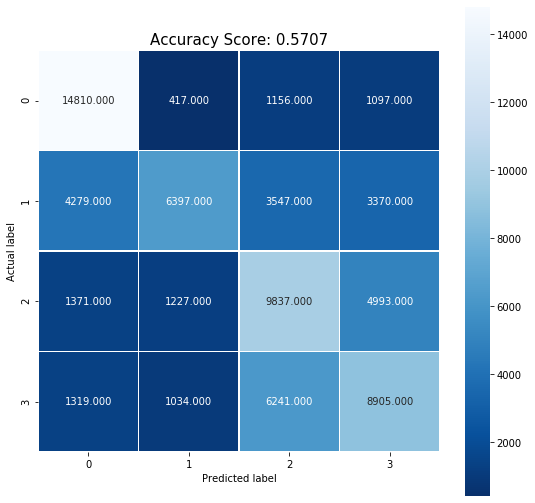

In [28]:
y_predict = rf_best.predict(x_test)
cm_rf = confusion_matrix(y_test, y_predict)

plt.figure(figsize=(9,9))
sns.heatmap(cm_rf, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(test_score)
plt.title(all_sample_title, size = 15);

In our matrix, looks like 0 is the best one, 2 is decent, while 1 and 3 have worse results.

## KNN Model

### Basic KNN

In [29]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(x_train,y_train)

train_score = knn.score(x_train,y_train)
test_score = knn.score(x_test,y_test)

print("Training Accuracy:",  train_score)
print("Testing Accuracy:",  test_score)

Training Accuracy: 0.6451428571428571
Testing Accuracy: 0.5045571428571428


### KNN Confusion Matrix

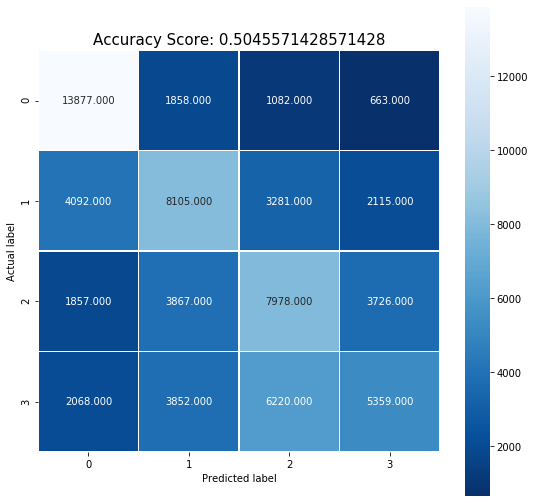

In [30]:
y_predict = knn.predict(x_test)

cm = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(test_score)
plt.title(all_sample_title, size = 15);

### KNN Hyperparameter Tuning

In [31]:
# KNN HyperParameters

# Number of neighbors to use by default for kneighbors queries.
n_neighbors = [ 5, 10, 15, 20, 30]
# Weight function used in prediction.
weights = ['uniform', 'distance']
# Algorithm used to compute the nearest neighbors:
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']

param_grid = {'n_neighbors': n_neighbors,
               'weights': weights,
               'algorithm': algorithm}

In [32]:
# Do not have to run this every time
# Tune hyperparams - 

t1 = time.time()

# Uncomment to run hypertuning
# knn_hyper = hypertuning_fxn(x_train, y_train, nfolds = 3, model = knn , param_grid = param_grid, cv = True, return_train_score = True, verbose= True)

t2 = time.time()  

run_time = t2 - t1
print('Training Time in Minutes:', run_time/60)

# print(knn_hyper.best_estimator_)

Training Time in Minutes: 7.033348083496094e-07


### Evaluate data using hypertuned KNN

In [33]:
# Last best estimator: 
# knn_best = KNeighborsClassifier()

# knn_best.fit(x_train, y_train)
# train_score = knn_best.score(x_train, y_train)
# test_score = knn_best.score(x_test, y_test)
# print("Training Accuracy:",  train_score)
# print("Testing Accuracy:",  test_score)